# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [154]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [53]:
data_dir = 'data2' 

In [152]:
img = cv2.imread(os.path.join("data2","potato","img1.jpg"))

In [153]:
img.shape

(256, 256, 3)

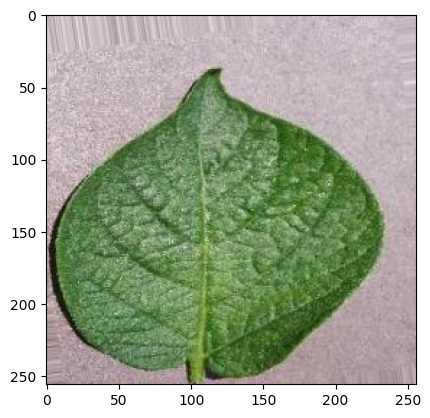

In [157]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [54]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [158]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [55]:
data = tf.keras.utils.image_dataset_from_directory('data2')

Found 470 files belonging to 2 classes.


In [56]:
data_iterator = data.as_numpy_iterator()

In [57]:
batch = data_iterator.next()

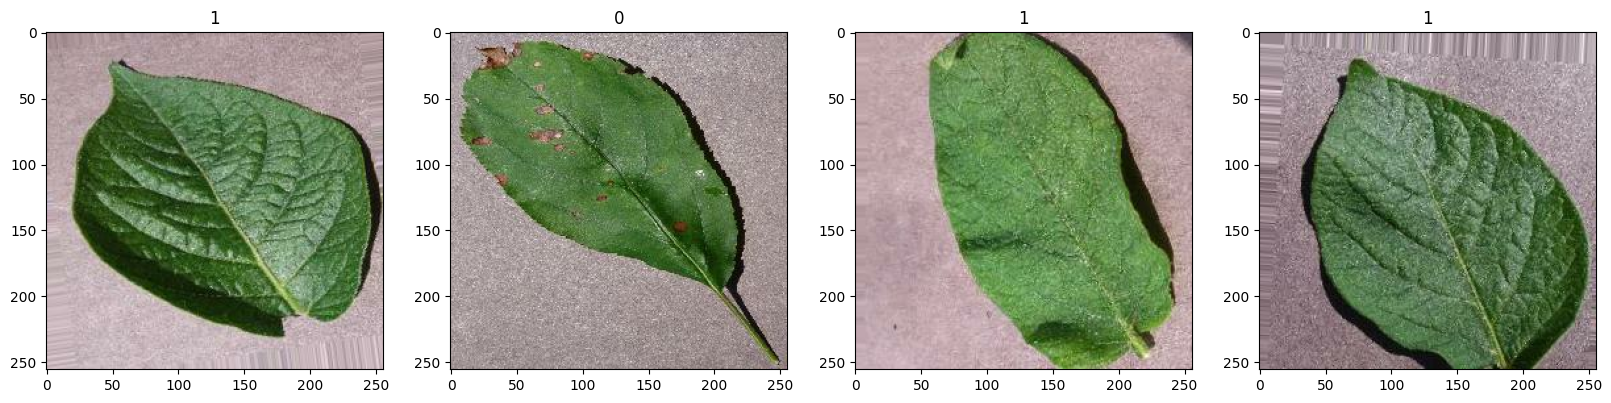

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [59]:
data = data.map(lambda x,y: (x/255, y))

In [60]:
data.as_numpy_iterator().next()

(array([[[[0.80784315, 0.7490196 , 0.76862746],
          [0.80784315, 0.7490196 , 0.76862746],
          [0.80784315, 0.7490196 , 0.76862746],
          ...,
          [0.8039216 , 0.7529412 , 0.78039217],
          [0.8235294 , 0.77254903, 0.8       ],
          [0.827451  , 0.7764706 , 0.8039216 ]],
 
         [[0.80784315, 0.7490196 , 0.76862746],
          [0.80784315, 0.7490196 , 0.76862746],
          [0.80784315, 0.7490196 , 0.76862746],
          ...,
          [0.8235294 , 0.77254903, 0.8       ],
          [0.8392157 , 0.7882353 , 0.8156863 ],
          [0.84313726, 0.7921569 , 0.81960785]],
 
         [[0.7921569 , 0.73333335, 0.7529412 ],
          [0.7921569 , 0.73333335, 0.7529412 ],
          [0.7921569 , 0.73333335, 0.7529412 ],
          ...,
          [0.81960785, 0.76862746, 0.79607844],
          [0.83137256, 0.78039217, 0.80784315],
          [0.827451  , 0.7764706 , 0.8039216 ]],
 
         ...,
 
         [[0.77254903, 0.69803923, 0.72156864],
          [0.77254

# 5. Split Data

In [61]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [62]:
train_size

10

In [63]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [64]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [65]:
model = Sequential()

In [66]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [69]:
logdir='logs'

In [70]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [71]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


10/10 [==============================] - 8s 635ms/step - loss: 0.7945 - accuracy: 0.5500 - val_loss: 0.6491 - val_accuracy: 0.5938
Epoch 2/20
10/10 [==============================] - 6s 595ms/step - loss: 0.5395 - accuracy: 0.7500 - val_loss: 0.4203 - val_accuracy: 0.8646
Epoch 3/20
10/10 [==============================] - 6s 606ms/step - loss: 0.2793 - accuracy: 0.9156 - val_loss: 0.1323 - val_accuracy: 0.9688
Epoch 4/20
10/10 [==============================] - 6s 598ms/step - loss: 0.1462 - accuracy: 0.9406 - val_loss: 0.1808 - val_accuracy: 0.9167
Epoch 5/20
10/10 [==============================] - 6s 589ms/step - loss: 0.1381 - accuracy: 0.9344 - val_loss: 0.3705 - val_accuracy: 0.8021
Epoch 6/20
10/10 [==============================] - 6s 592ms/step - loss: 0.1073 - accuracy: 0.9531 - val_loss: 0.0320 - val_accuracy: 0.9896
Epoch 7/20
10/10 [==============================] - 7s 638ms/step - loss: 0.0679 - accuracy: 0.9688 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 8/20
10/10 

# 8. Plot Performance

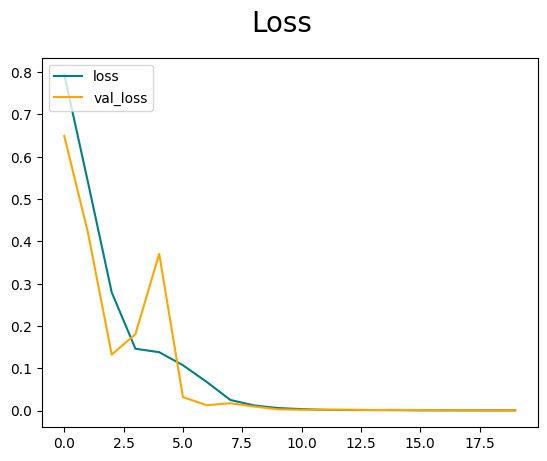

In [72]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

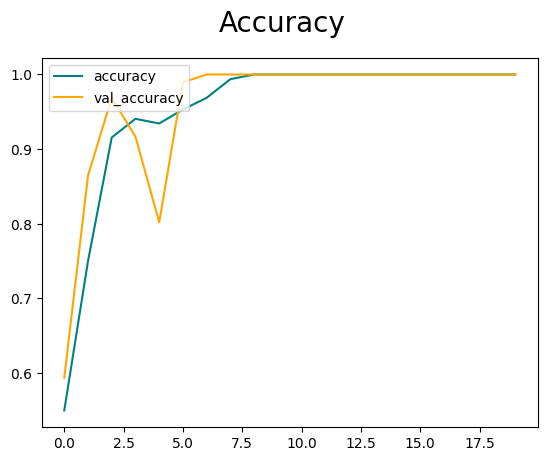

In [73]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [74]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [75]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 187ms/step


In [76]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [102]:
import cv2

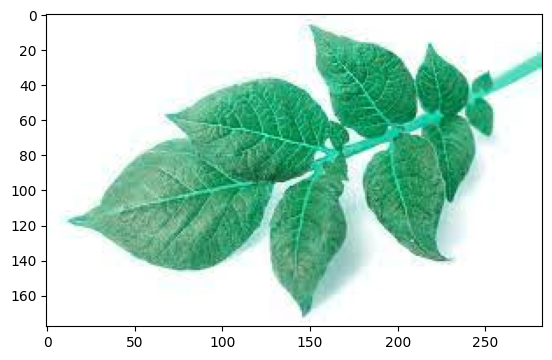

In [169]:
img = cv2.imread('lakhoaitay1.jpg')
plt.imshow(img)
plt.show()

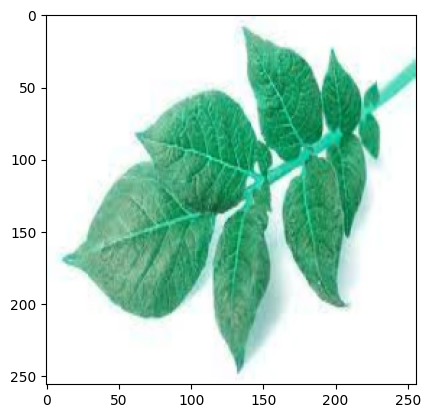

In [170]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [171]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 197ms/step


In [172]:
yhat

array([[0.9999971]], dtype=float32)

In [173]:
if yhat > 0.5: 
    # print(f'Predicted class is Sad')
    print("potato")
else:
    # print(f'Predicted class is Happy')
    print("apple")

potato


# 11. Save the Model

In [159]:
from tensorflow.keras.models import load_model

In [160]:
model.save(os.path.join('models','imageclassifier2.h5'))

In [163]:
new_model = load_model('imageclassifier2.h5')

OSError: No file or directory found at imageclassifier2.h5

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)